## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [35]:
#!pip install -U -q tensorflow tensorflow_datasets
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from keras import Sequential


# Set the seed value for experiment reproducibility.
seed = 42
#Test

tf.random.set_seed(seed)
np.random.seed(seed)

## Import the IRMAS Data set

Download and extract the `IRMAS-TrainingData.zip` file containing the smaller Audio inserts datasets with `tf.keras.utils.get_file`:

In [4]:
MODEL_NAME = 'CNN_Audio_Classifyer_Testing_Model'
DATASET_PATH = 'data/IRMAS-TrainingData'

data_dir = pathlib.Path(DATASET_PATH)
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.txt') & (commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['pia' 'voi' 'tru' 'sax' 'org' 'cla' 'gac' 'vio' 'flu' 'gel' 'cel']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [7]:
'''
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

'''

import os
import numpy as np
import librosa


fixed_length = 48000
# Define the directory containing the audio files
data_dir = data_dir

# Define the batch size and validation split
batch_size = 64
validation_split = 0.2

# Get a list of all the audio file paths in the directory
audio_files = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

# Get the class names from the subdirectories of the data directory
class_names = [dir for dir in os.listdir(data_dir) if dir != '.DS_Store']
num_classes = len(class_names)

label_names = np.array(class_names)
print("label names:", label_names)

# Define a function to load and preprocess each audio file
def load_audio(file_path):
    # Load the audio file using librosa
    signal, sr = librosa.load(file_path, sr=None, mono=False)

    # Pad or truncate the signal to a fixed length
    target_length = fixed_length
    if signal.shape[1] < target_length:
        signal = np.pad(signal, ((0, 0), (0, target_length - signal.shape[1])), mode="constant")
    else:
        signal = signal[:, :target_length]

    # Rescale the signal to be between -1 and 1
    signal = signal / np.max(np.abs(signal))

    return signal.T

# Split the audio files into training and validation sets
num_files = len(audio_files)
# Shuffle the audio files
np.random.shuffle(audio_files)

# Split the files into training and validation sets
split_index = int(num_files * (1 - validation_split))
train_files = audio_files[:split_index]
val_files = audio_files[split_index:]

# Create NumPy arrays for the input features and target labels
train_features = np.zeros((len(train_files), fixed_length, 2), dtype=np.float32)
train_labels = np.zeros((len(train_files),), dtype=np.int32)
for i, file_path in enumerate(train_files):
    train_features[i] = load_audio(file_path)
    train_labels[i] = class_names.index(os.path.basename(os.path.dirname(file_path)))

val_features = np.zeros((len(val_files), fixed_length, 2), dtype=np.float32)
val_labels = np.zeros((len(val_files),), dtype=np.int32)
for i, file_path in enumerate(val_files):
    val_features[i] = load_audio(file_path)
    val_labels[i] = class_names.index(os.path.basename(os.path.dirname(file_path)))

# Create TensorFlow Datasets for training and validation
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(batch_size)



label names: ['pia' 'voi' 'tru' 'sax' 'org' 'cla' 'gac' 'vio' 'flu' 'gel' 'cel']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [8]:
for waveform, sample_rate in train_ds.take(1):
    print("shape:", waveform.shape)
print(train_ds.element_spec)

shape: (64, 48000, 2)
(TensorSpec(shape=(None, 48000, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [9]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels
def squeeze_duel_channel(audio, labels):
  audio = tf.squeeze(tf.reduce_mean(audio, axis=-1, keepdims=True), axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze_duel_channel, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze_duel_channel, tf.data.AUTOTUNE)

In [10]:
print(train_ds.element_spec)

(TensorSpec(shape=(None, 48000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [11]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [12]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 48000)
(64,)


2023-05-05 19:22:41.907944: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Let's plot a few audio waveforms:

In [13]:
label_names[[1,1,3,0]]

array(['voi', 'voi', 'sax', 'pia'], dtype='<U3')

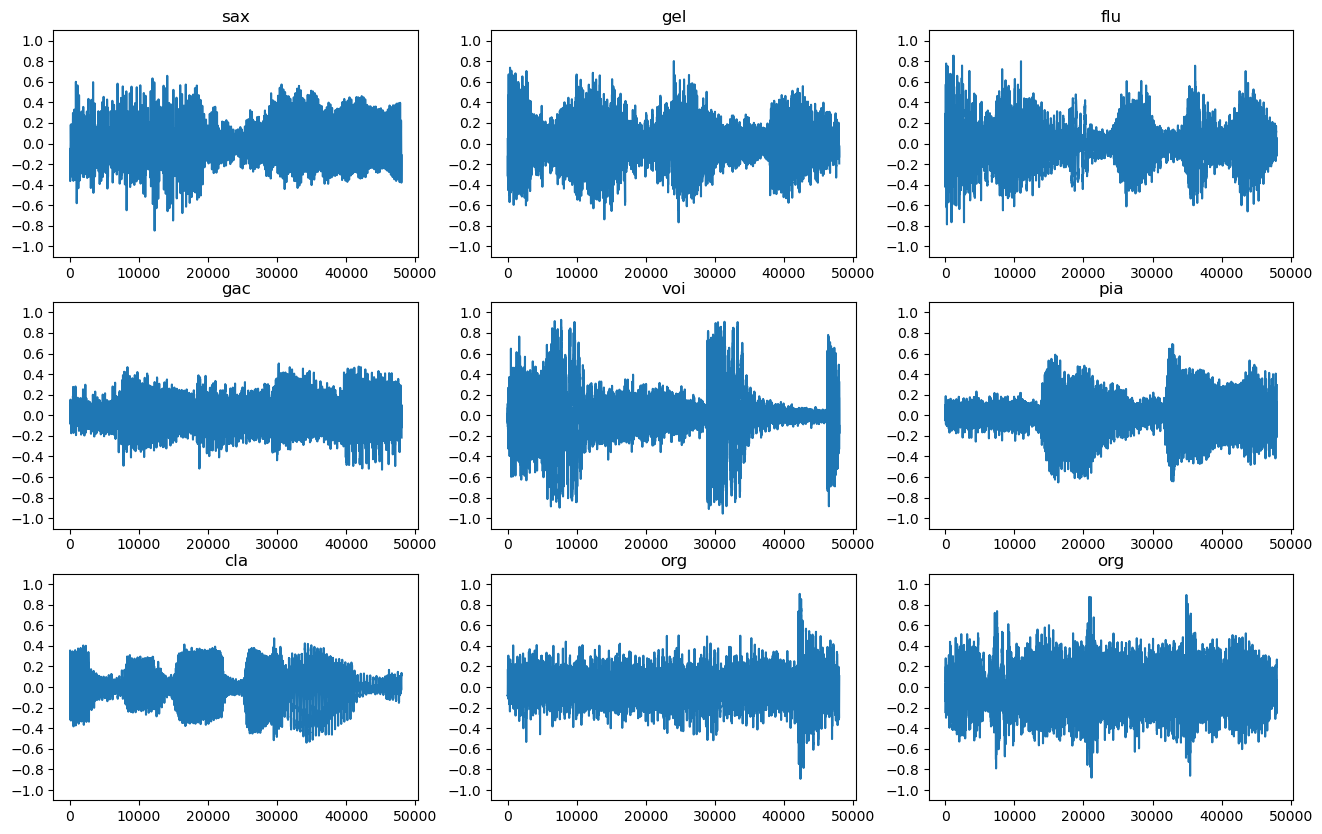

In [14]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [15]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [16]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=48000))

Label: sax
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: gel
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: flu
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [17]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

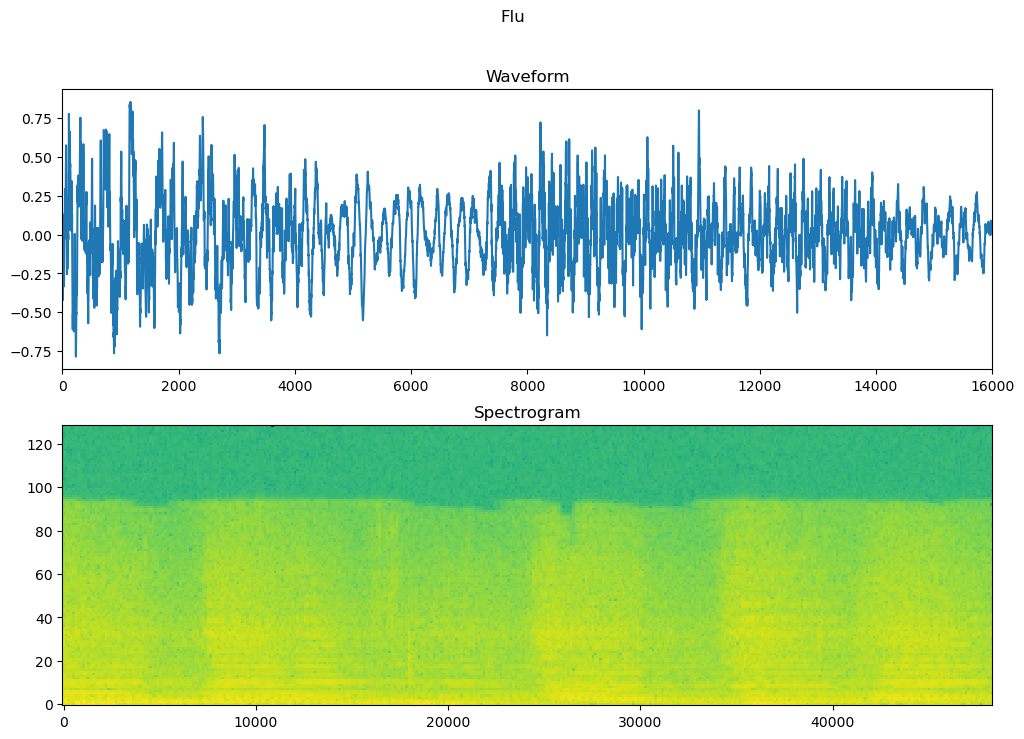

In [18]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [19]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [21]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

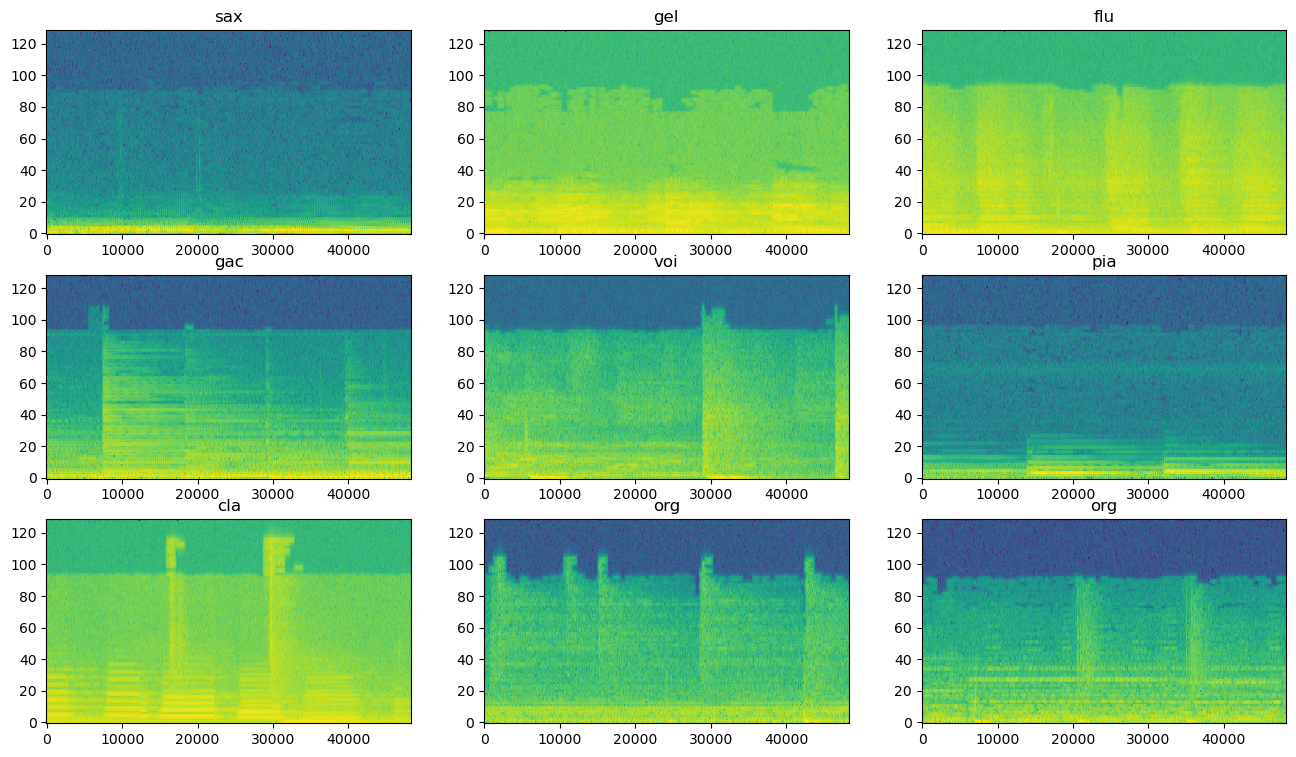

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [23]:
train_spectrogram_dss = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_dss = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_dss = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [24]:

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
'''
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary() '''

Input shape: (374, 129, 1)


"\n# Instantiate the `tf.keras.layers.Normalization` layer.\nnorm_layer = layers.Normalization()\n# Fit the state of the layer to the spectrograms\n# with `Normalization.adapt`.\nnorm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))\n\nmodel = models.Sequential([\n    layers.Input(shape=input_shape),\n    # Downsample the input.\n    layers.Resizing(32, 32),\n    # Normalize.\n    norm_layer,\n    layers.Conv2D(32, 3, activation='relu'),\n    layers.Conv2D(64, 3, activation='relu'),\n    layers.MaxPooling2D(),\n    layers.Dropout(0.25),\n    layers.Flatten(),\n    layers.Dense(128, activation='relu'),\n    layers.Dropout(0.5),\n    layers.Dense(num_labels),\n])\n\nmodel.summary() "

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [25]:
'''
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
'''

"\nmodel.compile(\n    optimizer=tf.keras.optimizers.Adam(),\n    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n    metrics=['accuracy'],\n)\n"

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Define the model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(374, 129, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4), # Increase dropout rate
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4), # Increase dropout rate
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4), # Increase dropout rate
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)), # Reduce number of neurons in dense layer
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(11, activation='softmax')
])

opt = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)



model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 372, 127, 32)      320       
                                                                 
 batch_normalization_6 (Batc  (None, 372, 127, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 186, 63, 32)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 186, 63, 32)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 184, 61, 64)       18496     
                                                                 
 batch_normalization_7 (Batc  (None, 184, 61, 64)      2

Train the model over 10 epochs for demonstration purposes:

Epoch 1/2
84/84 [==============================] - 21s 244ms/step - loss: 0.9982 - accuracy: 0.8005 - val_loss: 4.2296 - val_accuracy: 0.0953
Epoch 2/2
84/84 [==============================] - 20s 242ms/step - loss: 0.5716 - accuracy: 0.9394 - val_loss: 4.6349 - val_accuracy: 0.0875


Text(0, 0.5, 'Accuracy [%]')

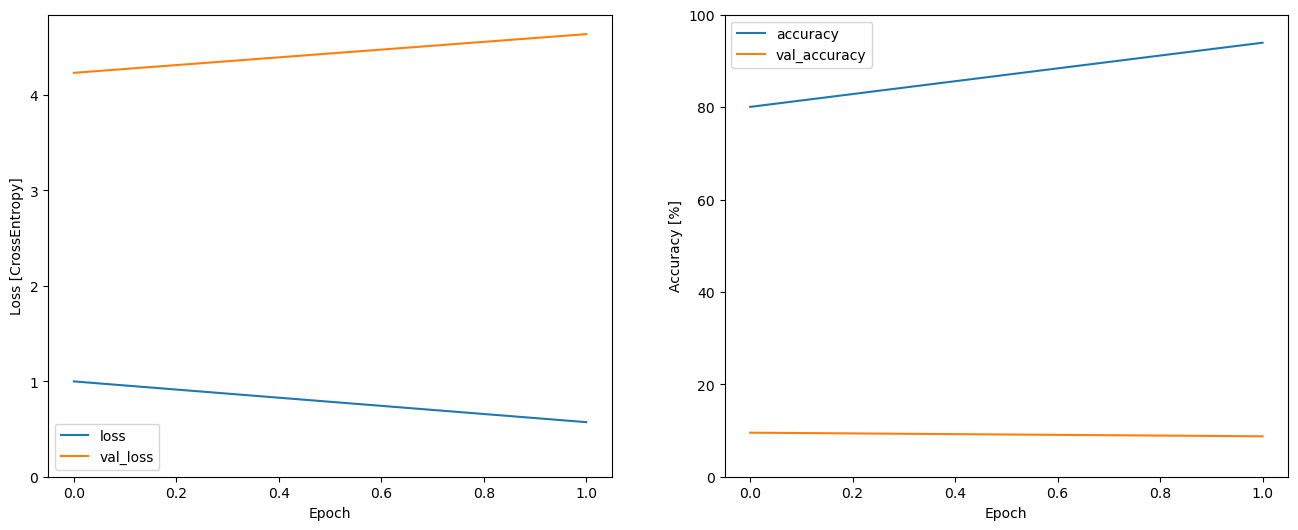

In [35]:
train_spectrogram_dsss = train_spectrogram_dss.map(lambda x, y: (x, tf.one_hot(y, depth=num_labels)))
val_spectrogram_dsss = val_spectrogram_dss.map(lambda x, y: (x, tf.one_hot(y, depth=num_labels)))
test_spectrogram_dsss = test_spectrogram_dss.map(lambda x, y: (x, tf.one_hot(y, depth=num_labels)))

EPOCHS = 2
history = model.fit(
    train_spectrogram_dsss,
    validation_data=val_spectrogram_dsss,
    epochs=EPOCHS,
    callbacks=[early_stop],
)


metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
#model.save('./models/' + MODEL_NAME + '.h5')

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

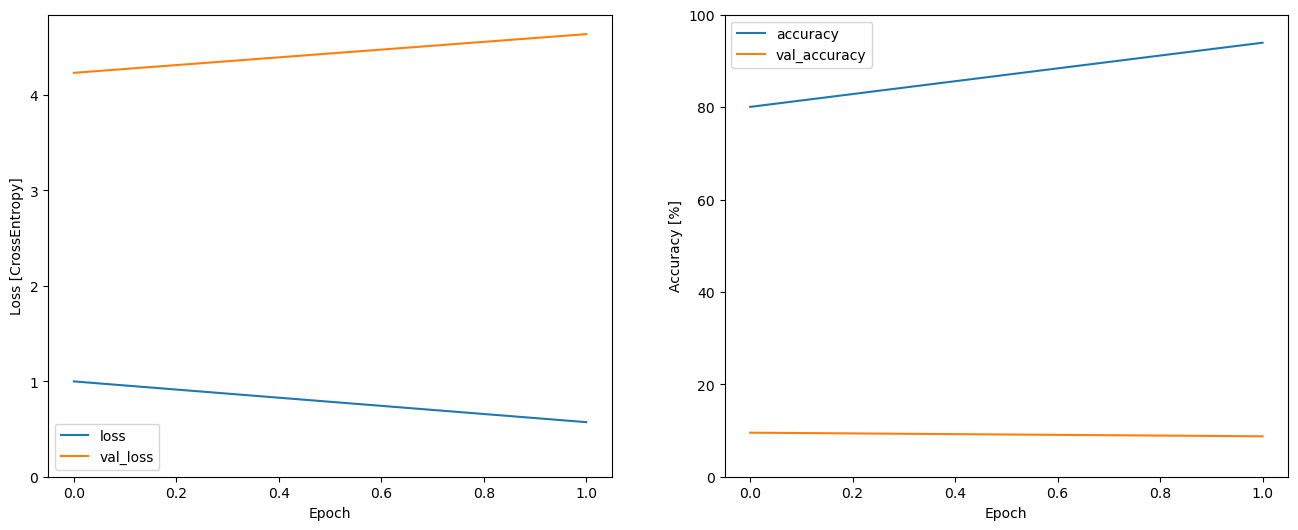

In [36]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [37]:
model.evaluate(test_spectrogram_dsss, return_dict=True)

11/11 [==============================] - 1s 76ms/step - loss: 4.5522 - accuracy: 0.0799


{'loss': 4.552175045013428, 'accuracy': 0.07988587766885757}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [42]:
y_pred = model.predict(test_spectrogram_dsss)

11/11 [==============================] - 1s 71ms/step


In [43]:
y_pred = tf.argmax(y_pred, axis=1)

In [40]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

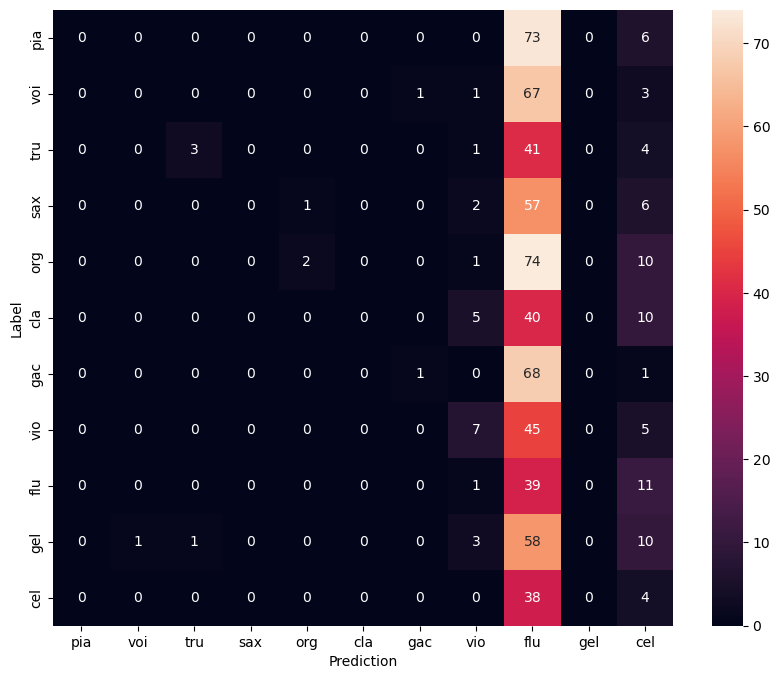

In [44]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

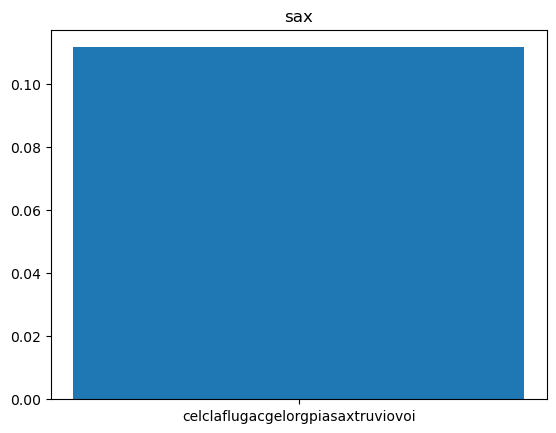

In [46]:
x = data_dir/'sax/[sax][cla]1573__1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=48000,)
x = tf.squeeze(tf.reduce_mean(x, axis=-1, keepdims=True), axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['cel' 'cla' 'flu' 'gac' 'gel' 'org' 'pia' 'sax' 'tru' 'vio' 'voi']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('sax')
plt.show()

display.display(display.Audio(waveform, rate=48000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'sax/[sax][cla]1573__1.wav')))

{'predictions': <tf.Tensor: shape=(1, 11), dtype=float32, numpy=
 array([[-0.6581765 ,  0.60372597, -0.17725576, -0.0593538 , -1.6176708 ,
         -1.7058074 ,  2.1032817 ,  0.585274  ,  0.58408266, -0.7824395 ,
         -2.7015028 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([6])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'pia'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, './models/' + MODEL_NAME)
imported = tf.saved_model.load('./models/' + MODEL_NAME)
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: ./models/CNN_Audio_Classifyer_Testing_Model/assets


INFO:tensorflow:Assets written to: ./models/CNN_Audio_Classifyer_Testing_Model/assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([6])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'pia'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 11), dtype=float32, numpy=
 array([[-0.6581765 ,  0.60372597, -0.17725576, -0.0593538 , -1.6176708 ,
         -1.7058074 ,  2.1032817 ,  0.585274  ,  0.58408266, -0.7824395 ,
         -2.7015028 ]], dtype=float32)>}

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The 
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.